In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
#sys.path.append("/home/mpim/m300517/Hausaufgaben/bdp_cnn/")
#sys.path.append("/home/mpim/m300517/PycharmProjects/enkf_lorenz_model/")
sys.path.append("/home/tobias/PycharmProjects/bdp_cnn/")
import enkf_lorenz
from bdp_cnn.cmip5.evaluater import Evaluater
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import os
import subprocess
import glob

Using TensorFlow backend.


In [2]:
# nc = Dataset("/home/mpim/m300517/Hausaufgaben/bdp_cnn/RMSE5.59_20180423_1852_18s.nc")
# nc = Dataset("/home/tobias/Downloads/runs/20180426_0338_08s/RMSE2.61_20180426_0338_08s.nc")
nc = Dataset("/home/tobias/Downloads/runs/20180426_0907_11s/RMSE2.49_20180426_0907_11s.nc")
print(nc)
print(nc.variables.keys())

ytest = nc.variables["true_values"][:].copy()
ypred = nc.variables["predictions"][:].copy()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    creation_date: Thu Apr 26 09:07:11 2018
    RMSE: 2.48967
    CORR: 0.99271
    Runtime: 49574.88
    dimensions(sizes): time(489), lat(192), lon(96)
    variables(dimensions): float64 true_values(time,lat,lon), float64 predictions(time,lat,lon)
    groups: 

odict_keys(['true_values', 'predictions'])


In [3]:
runtime = float(nc.getncattr("Runtime"))
time_steps = 12
batch_size = int(64/4)
neurons = 200
epochs = 600
nc.close()

In [4]:
print(ytest.shape)
print(ypred.shape)


(489, 192, 96)
(489, 192, 96)


plotting results as hist2d plot...
	 saving figure...


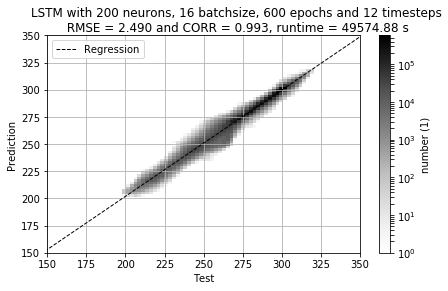

In [5]:
eval = Evaluater()
eval.hist2d(ytest, ypred, neurons, batch_size, epochs, time_steps, runtime, path="./")

In [6]:
plt.show()

In [7]:
print(np.mean(eval.corr_all))
print(np.mean(eval.rmse_all))

0.992713425879
2.48967191463


### Just out of curiosity have a look at the correlation distribution and the rmse distribution

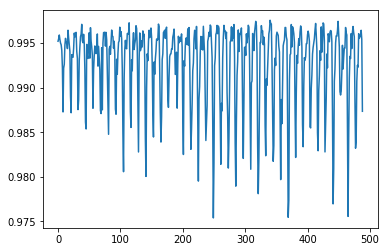

In [8]:
rmse = np.asarray(eval.rmse_all)
corr = np.asarray(eval.corr_all)

plt.plot(corr)
plt.show()

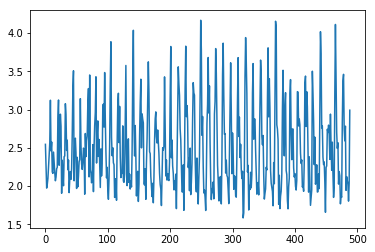

In [9]:
plt.plot(rmse)
plt.show()

It seems like there is a discrete frequency between increesing and decreesing of both maxima.
A fourier transform might bring more information on this

### Plot fourier transform of rmse and corr

/home/tobias/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tobias/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


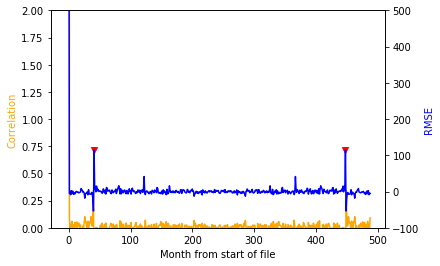

In [15]:
f_rmse = np.fft.fft(rmse)
f_corr = np.fft.fft(corr)
fig,ax = plt.subplots()

freqs_rmse = np.where(f_rmse>100)
val_freqs_rmse = f_rmse[freqs_rmse]

freqs_corr = np.where(f_corr>0.25)
val_freqs_corr = f_corr[freqs_corr]

ax.plot(f_corr,color="orange")
ax.set_ylim(0,2)
ax.set_ylabel("Correlation",color="orange")
ax.set_xlabel("Month from start of file")

ax2 = ax.twinx()
ax2.plot(f_rmse, color="b")
ax2.set_ylabel("RMSE",color="b")
ax2.set_ylim(-100,500)
ax2.scatter(freqs_rmse,val_freqs_rmse,color="red",marker="v")
plt.show()

In [16]:
print(freqs_rmse)
print(freqs_corr)

(array([  0,  41, 448]),)
(array([  0,  40, 449]),)


So apperantly in a 41 month cycle the results seem to have a local maximum in rmse and every 40 month in correlation.
Next step might be to determin wether correlation is good where there is local rmse and vice versa.
Furthermore we can look at the distribution of the rmse, maybe be creating a video.

### Have a deeper look in how correlation and rmse play together:

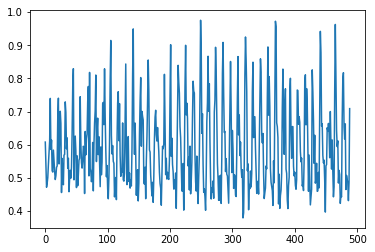

In [12]:
rmse_scaled = np.divide(np.abs(rmse),np.max(rmse))

plt.plot(np.multiply(corr,rmse_scaled))
plt.show()

In [13]:
def generate_video(img,lon,lat,folder):
    X, Y = np.meshgrid(lon, lat)
    
    for i in range(len(img)):
        fig, ax = plt.subplots(figsize=(7, 4))
        earth = Basemap()
        earth.drawcoastlines()

        levels = np.linspace(-8.5, 8.5, 18, endpoint=True)
        ticks = np.linspace(-8, 8, 9, endpoint=True)

        cp = plt.contourf(X, Y, img[i,:,:], cmap=cm.seismic, levels=levels, extend="both", alpha=0.9)
        cb = plt.colorbar(cp, ticks=ticks)
        cb.set_label(r'CMIP5 Temperature - Pred. Temperature ($\Delta{}$K)')
        plt.savefig(folder+"temp_image%03d.png"%i,dpi=100)
        plt.close()
    
#     if folder != "":
#         os.chdir(folder)
#     subprocess.call([
#         'ffmpeg', '-framerate', '2', '-i', 'temp_image%03d.png', '-r', '30', '-pix_fmt', 'yuv420p',
#         'video.mp4'
#     ])
#     for file_name in glob.glob(folder + "temp_image*.png"):
#         os.remove(file_name)

In [ ]:
diff = np.subtract(ytest, ypred)

lat = np.linspace(-90, 90, 192)
lon = np.linspace(-180, 180, 96)
# generate_video(diff,lon,lat,folder="")


